In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import gzip,pickle,sys
import numpy as np
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
#from keras import backend as K

import numpy as np
import random
import matplotlib.pyplot as plt
from random import randint

import pandas as pd
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score

Using TensorFlow backend.


In [2]:
batch_size = 32
num_classes = 50
epochs = 100

In [3]:
# input image dimensions
img_rows, img_cols = 28, 28

def dataset_load(path):
    if path.endswith(".gz"):
        f=gzip.open(path,'rb')
    else:
        f=open(path,'rb')

    if sys.version_info<(3,):
        data=pickle.load(f)
    else:
        data=pickle.load(f,encoding="bytes")
    f.close()
    return data

In [4]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = dataset_load('./Nahidspickle.pkl.gz')


x_train=np.asarray(x_train)
x_test=np.asarray(x_test)

y_train=np.asarray(y_train)
y_test=np.asarray(y_test)



x_train, x_val, y_train, y_val= train_test_split(x_train, y_train, test_size=0.1) 

In [5]:
#if K.image_data_format() == 'channels_first':
#x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
#x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
#input_shape = (1, img_rows, img_cols)
#else:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_val /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
print(x_test.shape[0], 'test samples')

x_train shape: (10800, 28, 28, 1)
x_val shape: (1200, 28, 28, 1)
x_test shape: (3000, 28, 28, 1)
10800 train samples
1200 validation samples
3000 test samples


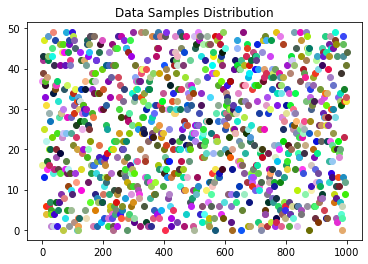

In [6]:
a = np.arange(0,1000,1)
#taking thousand random samples
b = np.random.choice(y_train, size=1000, replace=False)

#print(a, b)

for x, y in zip(a, b):
    rgb = np.random.rand(3,)
    plt.scatter(x, y, c=[rgb])
plt.title("Data Samples Distribution")
plt.show()

In [7]:
plt.savefig('Data Samples Distribution.png')

<Figure size 432x288 with 0 Axes>

In [8]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', 
                 activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 3), padding='same',  activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(Conv2D(256, (3, 3),padding='same',  activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))



In [9]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)        

In [10]:
#data augmentation
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images



In [11]:
earlystopper = EarlyStopping(patience=5, verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [12]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy', allow_pickle=True)[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [13]:
history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val), callbacks = [MetricsCheckpoint('logs'), learning_rate_reduction])
print(history)
model.save_weights("modelWeight.h5")
print('Save model to disk')
score = model.evaluate(x_test, y_test, verbose=0)

print(' Training Complete ')
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

Train on 10800 samples, validate on 1200 samples
Epoch 1/100
10800/10800 [==============================] - 15s 1ms/step - loss: 3.8982 - accuracy: 0.0235 - val_loss: 3.9033 - val_accuracy: 0.0267
Epoch 2/100
10800/10800 [==============================] - 6s 597us/step - loss: 3.7801 - accuracy: 0.0469 - val_loss: 3.5021 - val_accuracy: 0.1017
Epoch 3/100
10800/10800 [==============================] - 7s 668us/step - loss: 3.1352 - accuracy: 0.1649 - val_loss: 2.1669 - val_accuracy: 0.3808
Epoch 4/100
10800/10800 [==============================] - 7s 636us/step - loss: 2.1759 - accuracy: 0.3797 - val_loss: 1.2474 - val_accuracy: 0.6417
Epoch 5/100
10800/10800 [==============================] - 8s 715us/step - loss: 1.5252 - accuracy: 0.5463 - val_loss: 0.8800 - val_accuracy: 0.7458
Epoch 6/100
10800/10800 [==============================] - 8s 705us/step - loss: 1.1256 - accuracy: 0.6518 - val_loss: 0.6261 - val_accuracy: 0.8025
Epoch 7/100
10800/10800 [==============================] -

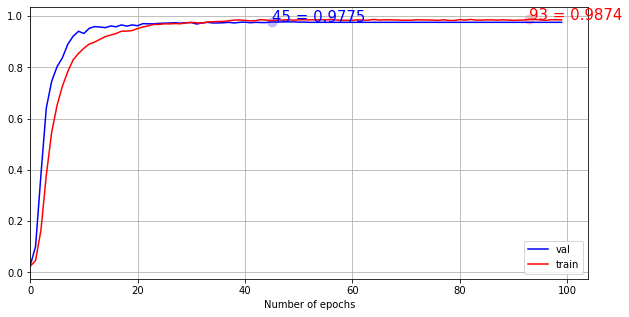

In [14]:
y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(y_test,axis=1)
plotKerasLearningCurve()
plt.show()  

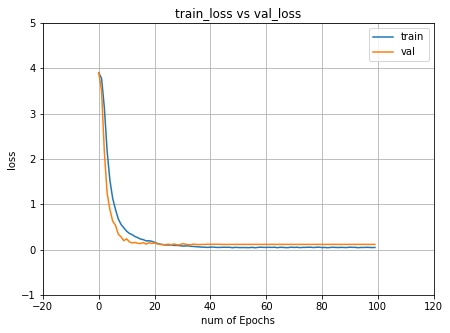

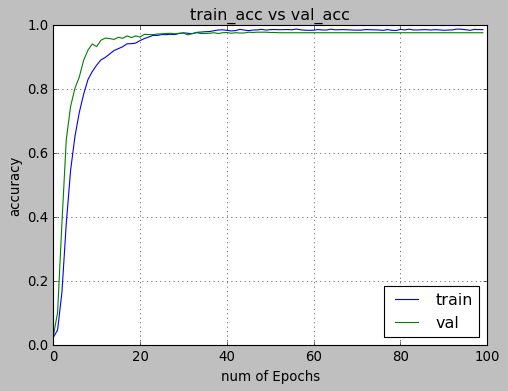

In [15]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
xc=range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])
plt.show()

In [16]:
model_json=model.to_json()
with open ("model.json","w") as json_file:
    json_file.write(model_json)
    print("Model Saved")

Model Saved


In [17]:
# load json and create model
#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
# load weights into new model
#loaded_model.load_weights("model_weights.h5")
#print("Loaded model from disk")

# evaluate loaded model on test data
#loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#score = loaded_model.evaluate(x_test, y_test, verbose=0)
#print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))